In [ ]:
#Mounting Google Drive
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [ ]:
#Loading the LoadCNNModel.py in colab environment that contains the model definitions
!cp /content/drive/My\ Drive/LoadCNNModel.py /content

Basic Modules

In [ ]:
import os
import numpy as np
import pandas as pd
import cv2
import tensorflow as tf
from tensorflow import keras
import zipfile
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import metrics
import itertools
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, CSVLogger,LearningRateScheduler
from tensorflow.keras.models import  load_model

from LoadCNNModel import loadVGG19Model

In [ ]:
#To check if GPU is enables
tf.test.gpu_device_name()

'/device:GPU:0'

Loading and Extracting Data

In [ ]:
BASE_PATH = '/content'
#Function for extracting dataset
def extract_dataset(path):

  zip_ref = zipfile.ZipFile(path, 'r')
  zip_ref.extractall(BASE_PATH)
  zip_ref.close()

In [ ]:
#Extracting the dataset
extract_dataset('/content/drive/My Drive/Research_Dataset/Dataset.zip')

In [ ]:
#Loading the train, test and validation image labels
train = pd.read_csv('/content/Dataset/train.csv')
test = pd.read_csv('/content/Dataset/test.csv')
val = pd.read_csv('/content/Dataset/val.csv')

In [ ]:
'''
Image Data Generator for loading the images for Train, Test and Validation Images 

1. flow_from_dataframe() : loads the images listed in the dataframe loaded in the previous step
by extracting the image name mentioned in "x_col" and the labels are in the "y_col"
the path for the images are set in the "directory" argument.

2. The real time augmentation are specified in the ImageDataGenerator object created for training "dataGenerator".
'''
image_size = 224

dataGenerator = ImageDataGenerator(horizontal_flip=True,
                                vertical_flip=True,
                                rotation_range=45,
                                width_shift_range=0.1,
                                height_shift_range=0.1,
                                zoom_range=.1,
                                fill_mode='nearest',
                                shear_range=0.1,
                                rescale=1/255,
                                )#validation_split=0.2

test_Data_Generator = ImageDataGenerator(rescale=1/255)                                
trainGenerator = dataGenerator.flow_from_dataframe(train,
                                        directory='/content/Dataset/Train',
                                        target_size=(image_size, image_size),
                                        x_col="Image",
                                        y_col=['lung_aca','lung_n','lung_scc'],
                                        class_mode='raw',
                                        shuffle=False,
                                        subset='training',
                                        batch_size=32)
validGenerator =  test_Data_Generator.flow_from_dataframe(val,
                                        directory='/content/Dataset/Val',
                                        target_size=(image_size,image_size),
                                        x_col="Image",
                                        y_col=['lung_aca','lung_n','lung_scc'],
                                        class_mode='raw',
                                        shuffle=False,
                                        batch_size=32)
test_gen = test_Data_Generator.flow_from_dataframe(test,
                                        directory='/content/Dataset/Test',
                                        target_size=(image_size,image_size),
                                        x_col="Image",
                                        y_col=['lung_aca','lung_n','lung_scc'],
                                        class_mode='raw',
                                        shuffle=False,
                                        batch_size=32)


In [ ]:
#Initializing the VGG19 model
modelvgg19 = loadVGG19Model((224,224,3),3)


80142336/80134624 [==============================] - 1s 0us/step


In [ ]:
#Printing the model summary
modelvgg19.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)      

In [ ]:
#Initilizing the optimizer 
adam = Adam(lr=0.0001)
model.compile(loss='categorical_crossentropy',optimizer=adam, metrics=['accuracy'])

In [ ]:
#Initializing the callbacks
log = CSVLogger('/content/drive/My Drive/Research_Dataset/VGG19/VGG19.csv')
lr_decay = LearningRateScheduler(schedule=lambda epoch: 0.0001 * np.exp(-epoch / 10.))
mc = ModelCheckpoint('/content/drive/My Drive/Research_Dataset/VGG19/rp_vgg19_model.h5', monitor='val_accuracy', mode='max', verbose=1, save_best_only=True)

In [ ]:
#Training the DenseNet model
train_step = trainGenerator.n//trainGenerator.batch_size
val_step = validGenerator.n//validGenerator.batch_size
history = model.fit_generator(generator=trainGenerator,
                                steps_per_epoch=train_step,
                                validation_data=validGenerator,
                                validation_steps=val_step,
                                epochs=30,callbacks=[log, mc,lr_decay])

Epoch 1/30
299/299 [==============================] - 172s 574ms/step - loss: 0.1347 - accuracy: 0.9495 - val_loss: 0.0455 - val_accuracy: 0.9842

Epoch 00001: val_accuracy improved from -inf to 0.98417, saving model to ./drive/My Drive/rp_vgg19_model.h5
Epoch 2/30
299/299 [==============================] - 166s 556ms/step - loss: 0.0323 - accuracy: 0.9883 - val_loss: 0.0011 - val_accuracy: 0.9962

Epoch 00002: val_accuracy improved from 0.98417 to 0.99625, saving model to ./drive/My Drive/rp_vgg19_model.h5
Epoch 3/30
299/299 [==============================] - 165s 550ms/step - loss: 0.0420 - accuracy: 0.9848 - val_loss: 6.0476e-04 - val_accuracy: 0.9967

Epoch 00003: val_accuracy improved from 0.99625 to 0.99667, saving model to ./drive/My Drive/rp_vgg19_model.h5
Epoch 4/30
299/299 [==============================] - 163s 545ms/step - loss: 0.0216 - accuracy: 0.9921 - val_loss: 0.0011 - val_accuracy: 0.9975

Epoch 00004: val_accuracy improved from 0.99667 to 0.99750, saving model to ./

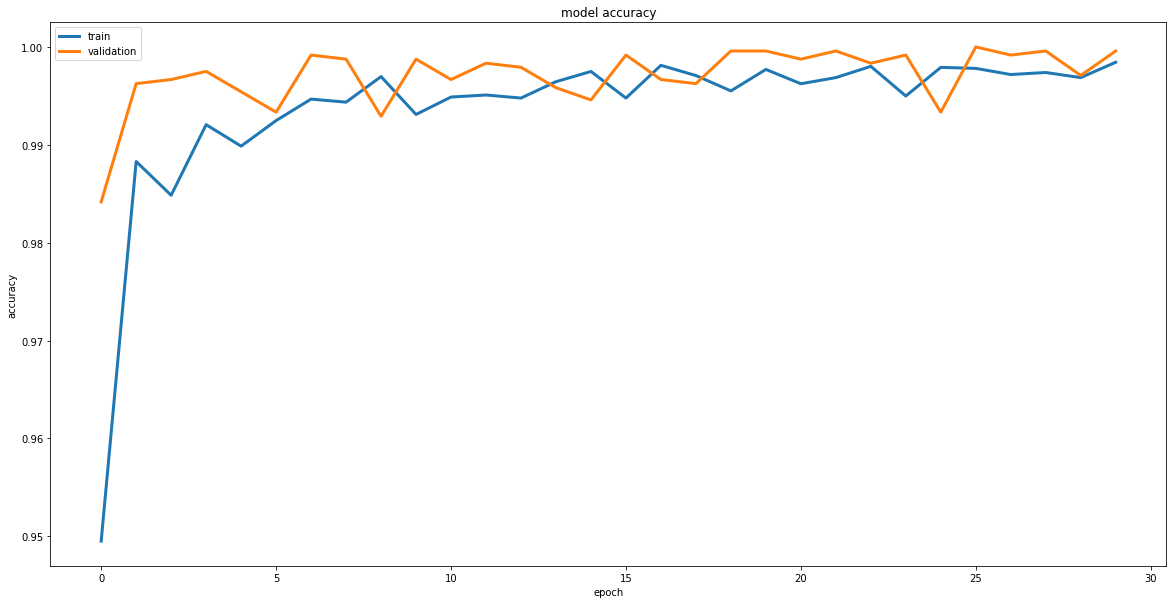

In [ ]:
#Plotting the train and validation accuracy curve
plt.figure(figsize=(20,10))
plt.plot(history.history['accuracy'],linewidth=3.0)
plt.plot(history.history['val_accuracy'],linewidth=3.0)
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

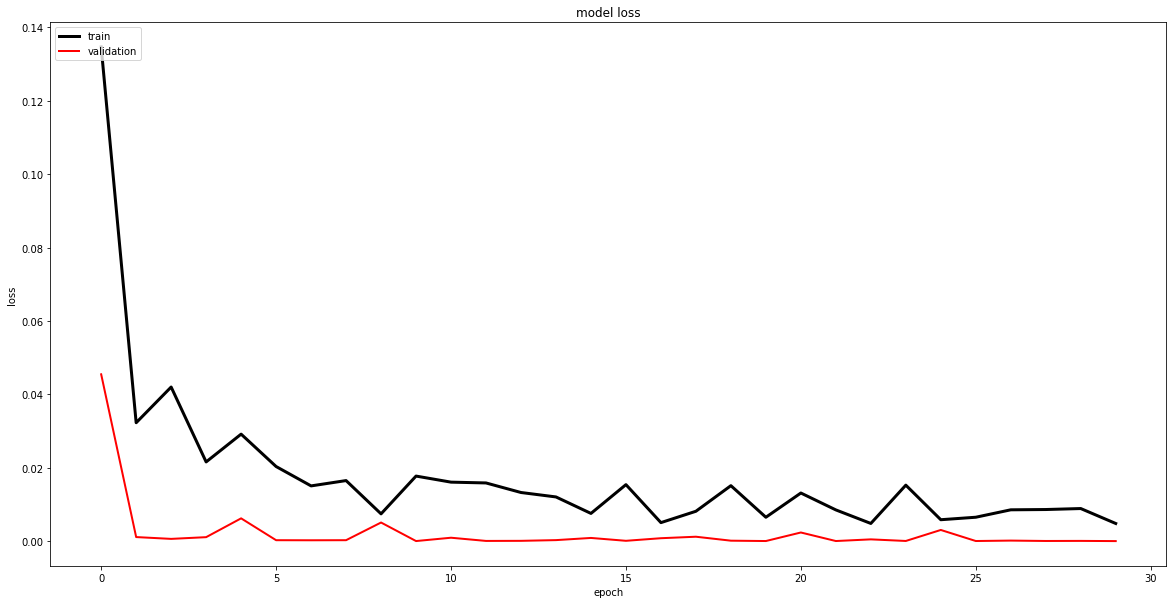

In [ ]:
#Plotting the training and validation loss curve
plt.figure(figsize=(20,10))
plt.plot(history.history['loss'], color='black',linewidth=3.0)
plt.plot(history.history['val_loss'],color='red',linewidth=2.0)
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [ ]:
#Loading the model for evaluation
from keras.models import  load_model
model = load_model('/content/drive/My Drive/Research_Dataset/VGG19/rp_vgg19_model.h5')

In [ ]:
#Evaluating the test accuracy
test_pred = model.evaluate_generator(test_gen,verbose=1)
print("Testing Accuracy :"+str(test_pred[1]))

Instructions for updating:
Please use Model.evaluate, which supports generators.
94/94 [==============================] - 18s 190ms/step - loss: 0.0030 - accuracy: 0.9990
Testing Accuracy :0.9990000128746033


In [ ]:
#Extracting the prediction made by the model
testin_predictions = model.predict(test_gen,verbose=1)
testin_predictions[0]

94/94 [==============================] - 17s 181ms/step


array([9.9999845e-01, 1.5606789e-06, 4.9734425e-09], dtype=float32)

In [ ]:
hist = pd.DataFrame(history.history)
hist.to_csv('./drive/My Drive/history_vgg19.csv')
hist.head()

In [ ]:
testin_predictionsb = (testin_predictions>0.5)
testin_predictionsb[0]

array([ True, False, False])

### Converting the prediction into string labels

The predictions are converted from label encodings to actual string labels.
"result" dataframe is created which has the predictied values


In [ ]:
predictions = testin_predictionsb.astype(int)

In [ ]:
columns = ['lung_aca', 'lung_n', 'lung_scc']

results = pd.DataFrame(predictions, columns=columns)
results['Image'] = test_gen.filenames
ordered_cols = ['Image'] + columns
results = results[ordered_cols]
results.head()

,Image,lung_aca,lung_n,lung_scc
0,lungaca1295.jpeg,1,0,0
1,lungaca249.jpeg,1,0,0
2,lungscc2058.jpeg,0,0,1
3,lungn4006.jpeg,0,1,0
4,lungn3434.jpeg,0,1,0


In [ ]:
'''
The "Predicted_CancerType" column of the "result" dataframe contains the
predicted cancer type.
'''
results['Image'] = test_gen.filenames
results.insert(4,'Predicted_CancerType', '', False)
ordered_cols = ['Image'] + columns + ['Predicted_CancerType']
results = results[ordered_cols]

for i in range(len(results)):
  if results.at[i,'lung_aca'] == 1:
    results.at[i,'Predicted_CancerType'] = 'lung_aca'
  elif results.at[i,'lung_n'] == 1:
    results.at[i,'Predicted_CancerType'] = 'lung_n'
  else:
    results.at[i,'Predicted_CancerType'] = 'lung_scc'

results.head()

,Image,lung_aca,lung_n,lung_scc,Predicted_CancerType
0,lungaca1295.jpeg,1,0,0,lung_aca
1,lungaca249.jpeg,1,0,0,lung_aca
2,lungscc2058.jpeg,0,0,1,lung_scc
3,lungn4006.jpeg,0,1,0,lung_n
4,lungn3434.jpeg,0,1,0,lung_n


In [ ]:
#Estimation of the Matthew's Correlation Coefficient
mcc = metrics.matthews_corrcoef(test['CancerType'], results['Predicted_CancerType'])
print("Matthews Correlation Coefficient: ", mcc)

Matthews Correlation Coefficient:  0.9985013062533264


In [ ]:
#Estimation of the F1 Score
print(metrics.classification_report(test['CancerType'], results['Predicted_CancerType'],columns))

              precision    recall  f1-score   support

    lung_aca       1.00      1.00      1.00       980
      lung_n       1.00      1.00      1.00      1017
    lung_scc       1.00      1.00      1.00      1003

    accuracy                           1.00      3000
   macro avg       1.00      1.00      1.00      3000
weighted avg       1.00      1.00      1.00      3000



In [ ]:
#Generating the confusion matrix
confusion_mtx = metrics.confusion_matrix(test['CancerType'], results['Predicted_CancerType'],columns)
confusion_mtx.T

array([[ 977,    0,    0],
       [   0, 1017,    0],
       [   3,    0, 1003]])

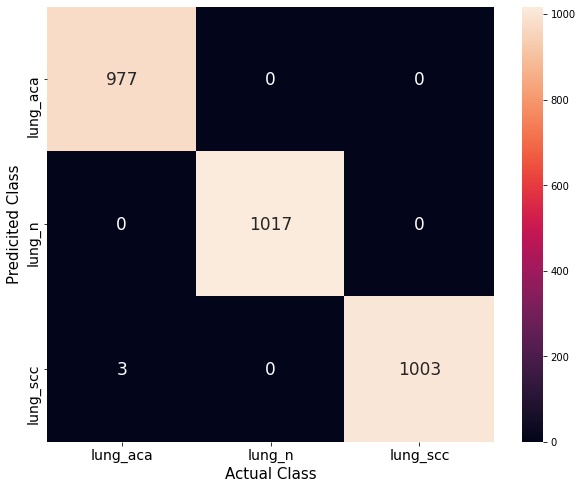

In [ ]:
#plotting the confusion matrix
plt.figure(figsize=(10,8))
ax= plt.subplot()
sns.heatmap(confusion_mtx.T, annot=True, ax = ax,fmt='g',annot_kws={"size": 17})
ax.xaxis.set_ticklabels(columns)
ax.yaxis.set_ticklabels(columns)
ax.xaxis.label.set_fontsize(15)
ax.yaxis.label.set_fontsize(15)
ax.set_xlabel('Actual Class')
ax.set_ylabel('Predicited Class')
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.show()